In [1]:
import sys
import yaml

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

sys.path.append('../src')
sys.path.append('../../../utils')

from unet import Unet
from isbi_em_dataset import ISBIEMDataset

from eval_utils import evaluate_model, get_pixel_accuracy
from train_utils import Trainer, he_init

/home/kramasamy/.venv/globalenv/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2024-12-22 07:57:36.568787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734834456.674189    4574 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734834456.692840    4574 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-22 07:57:36.857692: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow

In [2]:
# Load config.
with open('../configs/train_config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# Load dataset.
transform = transforms.Compose([
    transforms.ToTensor()
])
DATA_DIR = '/home/kramasamy/Code/projects/cnn/data/isbi_em_segmentation'
train_dataset = ISBIEMDataset(DATA_DIR, transform=transform, train=True)
test_dataset = ISBIEMDataset(DATA_DIR, transform=transform, train=False)

In [3]:
##Load model.
# Get dataset class frequency. 

In [4]:
# Load model.
model = Unet()
model.to('cuda')
model.apply(he_init)
trainer = Trainer(model, train_dataset, config)
result = trainer.train(print_loss=True)

tensor([0.7794, 0.2206])
Get loss fn with weighted loss.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 6.557863592108091


  5%|▌         | 1/20 [02:08<40:34, 128.16s/it]

Epoch 2/20, Loss: 0.46775389413038887


 10%|█         | 2/20 [04:18<38:51, 129.52s/it]

Epoch 3/20, Loss: 0.3993540515502294


 15%|█▌        | 3/20 [06:32<37:14, 131.44s/it]

Epoch 4/20, Loss: 0.3732383186618487


 20%|██        | 4/20 [09:40<41:04, 154.02s/it]

Epoch 5/20, Loss: 0.3716789638002714


 25%|██▌       | 5/20 [13:04<42:55, 171.72s/it]

Epoch 6/20, Loss: 0.36416771411895754


 30%|███       | 6/20 [15:21<37:21, 160.12s/it]

Epoch 7/20, Loss: 0.3428567921121915


 35%|███▌      | 7/20 [17:40<33:11, 153.20s/it]

Epoch 8/20, Loss: 0.33095313409964244


 40%|████      | 8/20 [20:00<29:45, 148.80s/it]

Epoch 9/20, Loss: 0.3188400030136108


 45%|████▌     | 9/20 [23:37<31:12, 170.27s/it]

Epoch 10/20, Loss: 0.3106537749369939


 50%|█████     | 10/20 [26:31<28:33, 171.39s/it]

Epoch 11/20, Loss: 0.30310235073169073


 55%|█████▌    | 11/20 [28:52<24:18, 162.07s/it]

Epoch 12/20, Loss: 0.3015852391719818


 60%|██████    | 12/20 [31:51<22:17, 167.17s/it]

Epoch 13/20, Loss: 0.28523619125286737


 65%|██████▌   | 13/20 [35:48<21:58, 188.37s/it]

Epoch 14/20, Loss: 0.28149322445193925


 70%|███████   | 14/20 [38:30<18:03, 180.51s/it]

Epoch 15/20, Loss: 0.2826651155948639


 75%|███████▌  | 15/20 [40:58<14:13, 170.76s/it]

Epoch 16/20, Loss: 0.2773067156473796


 80%|████████  | 16/20 [44:09<11:47, 176.87s/it]

Epoch 17/20, Loss: 0.2705154985189438


 85%|████████▌ | 17/20 [46:28<08:16, 165.36s/it]

Epoch 18/20, Loss: 0.2741810070971648


 90%|█████████ | 18/20 [48:47<05:15, 157.57s/it]

Epoch 19/20, Loss: 0.27253922844926515


 95%|█████████▌| 19/20 [51:07<02:32, 152.08s/it]

Epoch 20/20, Loss: 0.2679070490101973


100%|██████████| 20/20 [53:25<00:00, 160.29s/it]


In [5]:
import pickle as pkl
pkl.dump(result, open('../logs/train_unet.pkl', 'wb'))

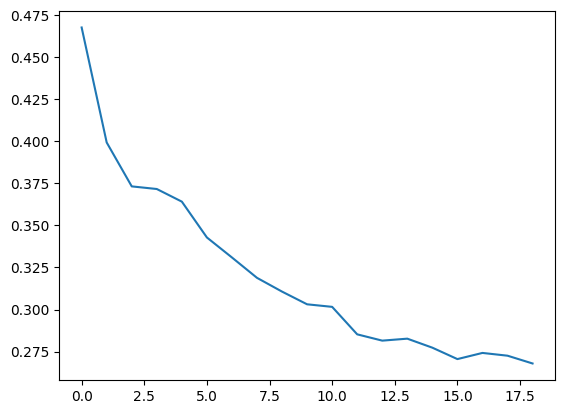

In [6]:
import matplotlib.pyplot as plt

plt.plot(result['loss_history'][1:])

In [7]:
torch.cuda.empty_cache()
train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
y_pred_train, y_true_train = evaluate_model(model, train_loader)
y_pred_test, y_true_test = evaluate_model(model, test_loader)

In [8]:
print(get_pixel_accuracy(y_pred_train, y_true_train))
print(get_pixel_accuracy(y_pred_test, y_true_test))

86.96206665039062
88.18379211425781


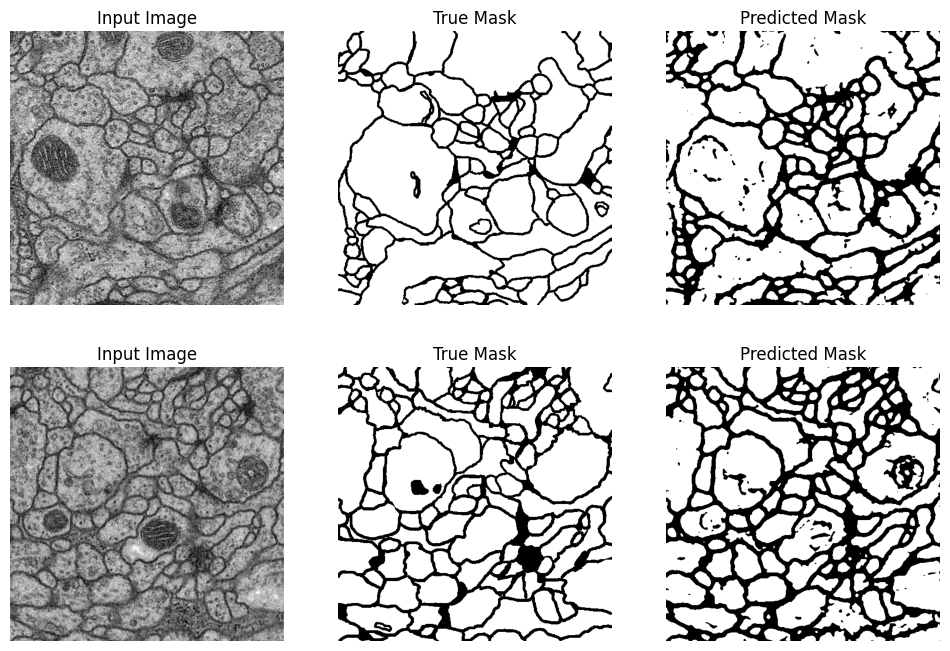

In [9]:
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Subset

n = 2 # Number to sample to examine.

random_indices = random.sample(range(len(test_dataset)), n)
random_subset = Subset(train_dataset, random_indices)
random_test_dataloader = DataLoader(random_subset, batch_size=2)
y_pred_logits, y_true = evaluate_model(model, random_test_dataloader)


fig, axes = plt.subplots(n, 3, figsize=(12, 4 * n))

for i in range(n):
    img = random_subset[i][0]
    # Plot input image (assuming the image has 3 channels or grayscale)
    axes[i, 0].imshow(img.squeeze().to('cpu'), cmap='gray')
    axes[i, 0].set_title("Input Image")
    axes[i, 0].axis('off')

    # Plot true mask
    axes[i, 1].imshow(y_true[i].to('cpu'), cmap='gray')
    axes[i, 1].set_title("True Mask")
    axes[i, 1].axis('off')

    # Plot predicted mask
    y_probs = F.softmax(y_pred_logits[i], dim=0)
    y_pred = torch.argmax(y_probs, dim=0)
    axes[i, 2].imshow(y_pred.to('cpu'), cmap='gray')
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis('off')